In [1]:
import torch
import torchvision
from torch import nn

# For train dataset
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Make Train Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [4]:
latent_dim = 100
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # Define the Generator's architecture
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # Define the Discriminator's architecture
    self.model = nn.Sequential(
      nn.Linear(28*28, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [6]:
# Loss function
criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

# Optimizers
G_optimizer = torch.optim.Adam(generator.model.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(discriminator.model.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
import torch.autograd as autograd

# Number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Flatten the images for the Discriminator
        images = images.view(images.size(0), -1)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(images.size(0), 1)
        fake_labels = torch.zeros(images.size(0), 1)

        ############################
        # Train the Discriminator
        ############################
        D_optimizer.zero_grad()

        # Compute BCELoss using real images
        outputs = discriminator(images)
        D_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim)
        fake_images = generator(z)

        # Compute BCELoss using fake images
        outputs = discriminator(fake_images.detach())
        D_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Optimize the Discriminator
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        ############################
        # Train the Generator
        ############################
        G_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim)
        fake_images = generator(z)

        # Compute BCELoss using fake images, with reversed labels
        outputs = discriminator(fake_images)
        G_loss = criterion(outputs, real_labels)

        # Optimize the Generator
        G_loss.backward()
        G_optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), D_loss.item(), G_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

Epoch [1/5], Step [100/938], D_loss: 1.2828, G_loss: 1.1491, D(x): 0.76, D(G(z)): 0.63
Epoch [1/5], Step [200/938], D_loss: 0.6351, G_loss: 1.2529, D(x): 0.76, D(G(z)): 0.28
Epoch [1/5], Step [300/938], D_loss: 0.6804, G_loss: 1.5901, D(x): 0.70, D(G(z)): 0.21
Epoch [1/5], Step [400/938], D_loss: 0.5536, G_loss: 1.8527, D(x): 0.76, D(G(z)): 0.15
Epoch [1/5], Step [500/938], D_loss: 0.2993, G_loss: 4.6338, D(x): 0.96, D(G(z)): 0.21
Epoch [1/5], Step [600/938], D_loss: 0.7652, G_loss: 2.2822, D(x): 0.67, D(G(z)): 0.14
Epoch [1/5], Step [700/938], D_loss: 0.8505, G_loss: 2.1016, D(x): 0.73, D(G(z)): 0.30
Epoch [1/5], Step [800/938], D_loss: 0.4524, G_loss: 3.2772, D(x): 0.88, D(G(z)): 0.22
Epoch [1/5], Step [900/938], D_loss: 0.3886, G_loss: 3.5686, D(x): 0.92, D(G(z)): 0.21
Epoch [2/5], Step [100/938], D_loss: 0.4127, G_loss: 2.5959, D(x): 0.84, D(G(z)): 0.15
Epoch [2/5], Step [200/938], D_loss: 0.4940, G_loss: 3.6445, D(x): 0.85, D(G(z)): 0.17
Epoch [2/5], Step [300/938], D_loss: 0.6052

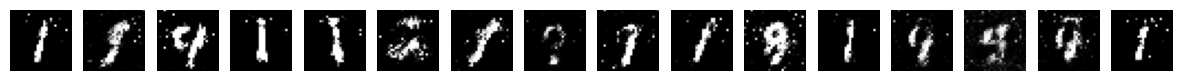

In [8]:
# Generate fake images for visualization
z = torch.randn(16, latent_dim)
fake_images = generator(z)
fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
fake_images = (fake_images + 1) / 2  # Rescale images to [0, 1]

# Plot the fake images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 16, figsize=(15, 15))
for ax, img in zip(axes.flatten(), fake_images):
    ax.axis('off')
    ax.set_adjustable('box')
    img = transforms.ToPILImage()(img.cpu().squeeze())
    ax.imshow(img, cmap='gray')
plt.show()